# Hill Climbing

### 0. Background: Directly Optimizing Policies

In the previous section, we discussed how **[value-based methods](../../../value-iteration/)** rely on estimating the optimal action-value function before deriving the optimal policy. However, **policy-based methods** take a different approach by directly optimizing the policy without the need to compute value functions. This is particularly useful in environments with **continuous action spaces**, where value-based methods struggle to scale effectively.

#### Representing Policies with Neural Networks

Using the **CartPole** example, the agent has two possible actions: it can push the cart either **to the left** or **to the right**. At each time step, the agent selects one action from these two options. 

We can represent the agent's policy using a neural network:
- The network takes the **state** of the environment as input.
- It outputs the **probabilities** of selecting each possible action. For example:
  - **90%** probability of "push left."
  - **10%** probability of "push right."

The agent interacts with the environment by:
1. Passing the current state into the network.
2. Sampling an action based on the output probabilities.
3. Executing the selected action in the environment.

#### Goal of Policy Optimization

The main goal of policy optimization is to adjust the **network weights** such that the policy maximizes the **expected return**. This is achieved by:
1. Iteratively improving the network weights through interaction with the environment.
2. Learning to assign higher probabilities to actions that yield higher rewards.

#### Black-Box Optimization Techniques

Let the **expected return** be denoted as $J$, and the neural network weights as $\theta$. There exists a mathematical relationship between $\theta$ and $J$, as $\theta$ encodes the policy, which influences:
- The likelihood of selecting certain actions.
- The rewards obtained from those actions.

Although the exact relationship between $J$ and $\theta$ may be complex, the goal remains the same: **maximize $J$ by finding the optimal values for $\theta$**. These methods treat the policy network as a **black box** and focus solely on maximizing the objective function $J(\theta)$ without requiring knowledge of its internal structure. This makes them versatile but less efficient compared to gradient-based methods.

#### Hill Climbing: A Simpler Approach

An alternative to gradient ascent is **hill climbing**, a simpler algorithm for optimizing policies:
1. Start with a random set of weights $\theta$.
2. Collect an episode using the policy defined by $\theta$ and record the return $G$.
3. Add random noise to $\theta$ to generate a new set of candidate weights $\theta_{\text{new}}$.
4. Evaluate the return $G_{\text{new}}$ for the new weights:
   - If $G_{\text{new}}$ is greater than the current best return, update $\theta_{\text{best}}$ to $\theta_{\text{new}}$.
   - Otherwise, keep the current $\theta_{\text{best}}$.
5. Repeat the process until the policy converges.

#### Advanced Variants of Hill Climbing

While hill climbing is simple to implement, it has some limitations:
- It can easily get stuck in **local optima**, failing to find the global maximum.
- The algorithm relies heavily on random perturbations, which may lead to inefficient exploration.

To address these limitations, several modifications can be applied:
1. **Steepest-Ascent Hill Climbing**:
   - Generate multiple candidate policies at each iteration.
   - Select the best policy among the candidates to update $\theta_{\text{best}}$.
2. **Simulated Annealing**:
   - Gradually reduce the magnitude of random perturbations as the policy converges.
   - This helps the algorithm focus on fine-tuning the policy near the optimal solution.
3. **Adaptive Noise Scaling**:
   - Increase the search radius when no improvement is found.
   - Decrease the search radius when a better policy is discovered.

In this notebook, we will train hill climbing with adaptive noise scaling with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import time
from PIL import Image
from IPython import display

%matplotlib inline

### 2. Define the Policy

In [6]:
env = gym.make('CartPole-v1')
print('observation space:\n', env.observation_space)
print('action space:\n', env.action_space)

class Policy:
    def __init__(self, s_size=4, a_size=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)  # weights for simple linear policy: state_space x action_space
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))
    
    def select_action(self, state):
        probs = self.forward(state)
        #action = np.random.choice(2, p=probs) # option 1: stochastic policy
        action = np.argmax(probs)              # option 2: deterministic policy
        return action

observation space:
 Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space:
 Discrete(2)


### 3. Train the Agent with Stochastic Policy Search

#### Basic Hill Climbing

1. Start with a random set of weights $\theta$.
2. Collect an episode using the policy defined by $\theta$ and record the return $G$.
3. Add random noise to $\theta$ to generate a new set of candidate weights $\theta_{\text{new}}$.
4. Evaluate the return $G_{\text{new}}$ for the new weights:
   - If $G_{\text{new}}$ is greater than the current best return, update $\theta_{\text{best}}$ to $\theta_{\text{new}}$ by decrease the search radius when a better policy is discovered.
   - Otherwise, Adaptive Noise Scaling by increase the search radius when no improvement is found.
5. Repeat the process until the policy converges.

In [30]:
np.random.seed(0)
env = gym.make('CartPole-v1')
policy = Policy()

In [ ]:
def hill_climbing(n_episodes=1000, max_t=1000, gamma=1.0, window=100, noise_scale=1e-2):
    """Implementation of hill climbing with adaptive noise scaling.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        window (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_window = deque(maxlen=window)
    scores = []

    best_R = -np.inf
    best_w = policy.w

    for i_episode in range(1, n_episodes + 1):
        rewards = []
        state, _ = env.reset()
        for t in range(max_t):
            action = policy.select_action(state)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

        scores_window.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards) + 1)]
        R = sum([a * b for a, b in zip(discounts, rewards)])
    
        if R >= best_R:  # found better weights
            best_R = R
            best_w = policy.w
            noise_scale = max(1e-3, noise_scale / 2)
            policy.w += noise_scale * np.random.rand(*policy.w.shape)
        else:  # did not find better weights
            noise_scale = min(2, noise_scale * 2)
            policy.w = best_w + noise_scale * np.random.rand(*policy.w.shape)

        if i_episode % window == 0:
            print(
                "Episode {}\tAverage Score: {:.2f}".format(
                    i_episode, np.mean(scores_window)
                )
            )
        if np.mean(scores_window) >= 195.0:
            print(
                "Environment solved in {:d} episodes!\tAverage Score: {:.2f}".format(
                    i_episode - window, np.mean(scores_window)
                )
            )
            policy.w = best_w
            break

    return scores


scores = hill_climbing(
    n_episodes=1000, max_t=1000, gamma=1.0, window=100, noise_scale=1e-2
)

Environment solved in -84 episodes!	Average Score: 216.75


### 4. Plot the Scores

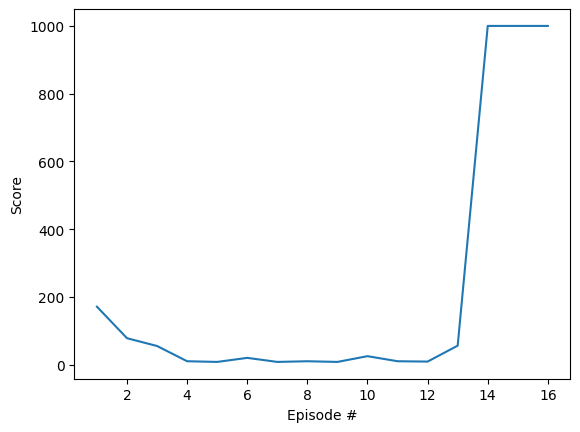

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

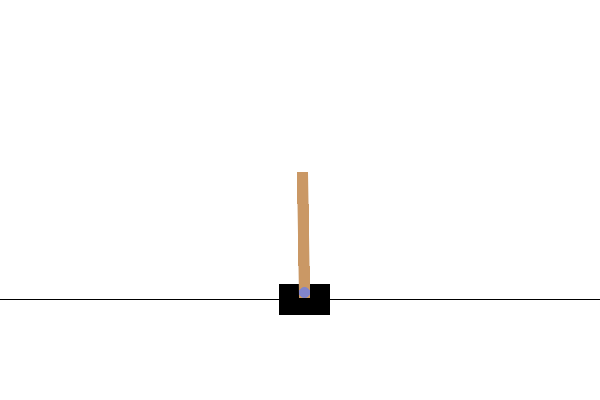

In [27]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
state, info = env.reset()
total_reward = 0
for t in range(200):
    # clear frame
    display.clear_output(wait=True)

    action = policy.select_action(state)

    # render game
    frame = env.render()
    display.display(Image.fromarray(frame))
    time.sleep(0.01)

    state, reward, done, _, info = env.step(action)
    total_reward += reward
    if done:
        break

env.close()